In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
import ast
import seaborn as sns

In [3]:
# Load CSV
df = pd.read_csv("../data/data.csv")

# Convert stringified list columns
df['genres'] = df['genres'].apply(ast.literal_eval)
df['privacy_types'] = df['privacy_types'].apply(ast.literal_eval)
df['data_categories'] = df['data_categories'].apply(ast.literal_eval)
df['data_types'] = df['data_types'].apply(ast.literal_eval)


In [4]:
# --- FEATURE ENCODING ---
# Base features
X_feats = pd.DataFrame()
X_feats['price'] = df['price']
X_feats['size'] = df['size']
X_feats['has_in_app_purchases'] = df['has_in_app_purchases'].astype(int)

# One-hot for country and rating
X_feats = pd.concat([
    X_feats,
    pd.get_dummies(df['country_code'], prefix='country'),
    pd.get_dummies(df['content_rating'], prefix='rating')
], axis=1)

In [5]:
# Multi-hot encode genres
mlb_genres = MultiLabelBinarizer()
genres = mlb_genres.fit_transform(df['genres'])
X_feats = pd.concat([X_feats, pd.DataFrame(genres, columns=[f"genre_{g}" for g in mlb_genres.classes_])], axis=1)

In [6]:
# --- LABELS ---
mlb_privacy = MultiLabelBinarizer()
mlb_categories = MultiLabelBinarizer()
mlb_types = MultiLabelBinarizer()

y_privacy = mlb_privacy.fit_transform(df['privacy_types'])
y_categories = mlb_categories.fit_transform(df['data_categories'])
y_types = mlb_types.fit_transform(df['data_types'])

In [7]:
# Combine Step 1 predicted outputs as inputs to Step 2
X_combined = np.concatenate([X_feats, y_privacy, y_categories], axis=1)
print("Combined input shape:", X_combined.shape)

# Normalize
scaler = StandardScaler()
X_combined = scaler.fit_transform(X_combined)

Combined input shape: (10000, 83)


In [8]:
X_tensor = torch.tensor(X_combined, dtype=torch.float32)
y_tensor = torch.tensor(y_types, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)


In [9]:
class DataTypePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=34):
        super(DataTypePredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [10]:
model = DataTypePredictor(input_dim=X_combined.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

f1_scores = []

for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Eval
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            probs = torch.sigmoid(model(xb))
            preds = (probs > 0.5).int().cpu().numpy()
            all_preds.append(preds)
            all_true.append(yb.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_true = np.vstack(all_true)
    f1 = f1_score(all_true, all_preds, average="micro")
    f1_scores.append(f1)
    print(f"Epoch {epoch+1}: F1 Score = {f1:.4f}")


Epoch 1: F1 Score = 0.7135
Epoch 2: F1 Score = 0.7771
Epoch 3: F1 Score = 0.8064
Epoch 4: F1 Score = 0.8200
Epoch 5: F1 Score = 0.8313
Epoch 6: F1 Score = 0.8347
Epoch 7: F1 Score = 0.8374
Epoch 8: F1 Score = 0.8421
Epoch 9: F1 Score = 0.8431
Epoch 10: F1 Score = 0.8443
Epoch 11: F1 Score = 0.8441
Epoch 12: F1 Score = 0.8452
Epoch 13: F1 Score = 0.8453
Epoch 14: F1 Score = 0.8459
Epoch 15: F1 Score = 0.8439
Epoch 16: F1 Score = 0.8467
Epoch 17: F1 Score = 0.8463
Epoch 18: F1 Score = 0.8465
Epoch 19: F1 Score = 0.8479
Epoch 20: F1 Score = 0.8459
Epoch 21: F1 Score = 0.8481
Epoch 22: F1 Score = 0.8482
Epoch 23: F1 Score = 0.8471
Epoch 24: F1 Score = 0.8489
Epoch 25: F1 Score = 0.8493
Epoch 26: F1 Score = 0.8480
Epoch 27: F1 Score = 0.8477
Epoch 28: F1 Score = 0.8483
Epoch 29: F1 Score = 0.8486
Epoch 30: F1 Score = 0.8452
Epoch 31: F1 Score = 0.8482
Epoch 32: F1 Score = 0.8466
Epoch 33: F1 Score = 0.8490
Epoch 34: F1 Score = 0.8499
Epoch 35: F1 Score = 0.8484
Epoch 36: F1 Score = 0.8500
E

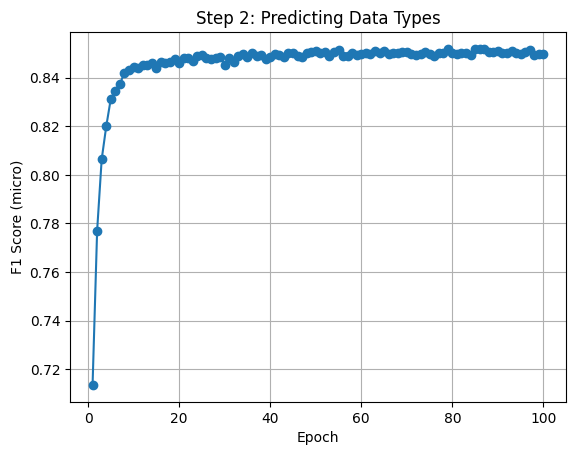

In [11]:
plt.plot(range(1, len(f1_scores)+1), f1_scores, marker="o")
plt.xlabel("Epoch")
plt.ylabel("F1 Score (micro)")
plt.title("Step 2: Predicting Data Types")
plt.grid(True)
plt.show()


In [12]:
print(classification_report(
    all_true, all_preds, 
    target_names=mlb_types.classes_,
    zero_division=0
))


                         precision    recall  f1-score   support

       Advertising Data       0.75      0.80      0.77       594
             Audio Data       0.58      0.15      0.24        92
       Browsing History       1.00      1.00      1.00        38
        Coarse Location       0.85      0.98      0.91       534
               Contacts       1.00      0.99      0.99        75
             Crash Data       0.96      1.00      0.98      1168
            Credit Info       0.50      0.12      0.20        16
       Customer Support       0.73      0.84      0.78       385
              Device ID       0.88      0.98      0.93       988
          Email Address       0.94      1.00      0.97       601
Emails or Text Messages       1.00      0.05      0.10        57
   Environment Scanning       0.00      0.00      0.00         1
                Fitness       0.57      0.53      0.55        32
       Gameplay Content       0.60      0.36      0.45        97
                  Hands 

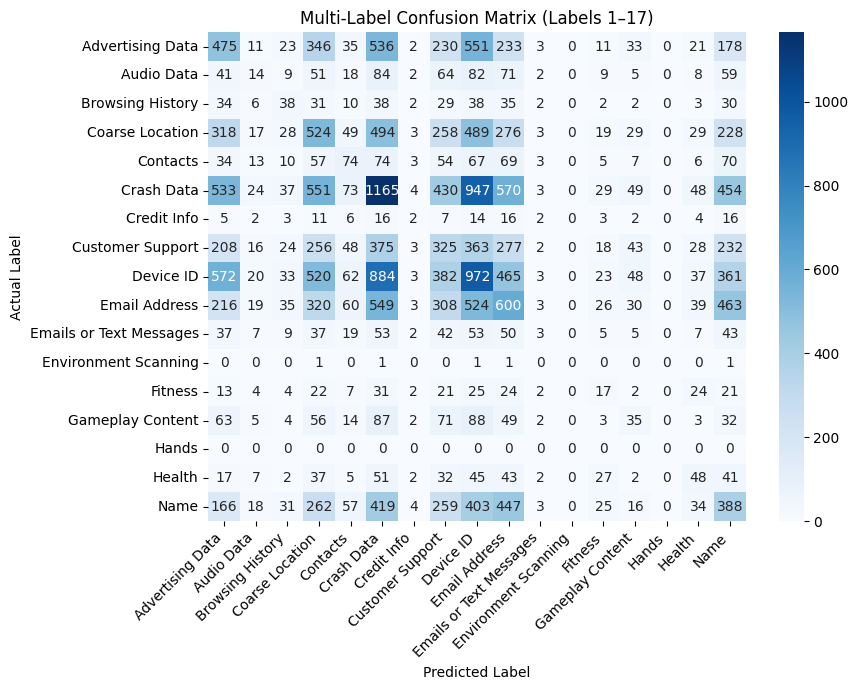

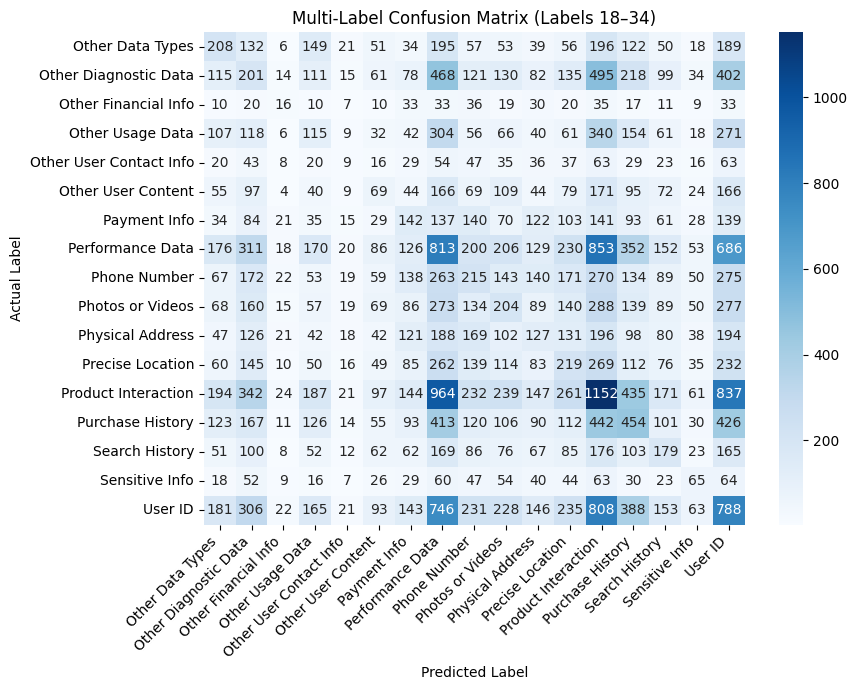

In [13]:
# Full matrix as before
n_labels = len(mlb_types.classes_)
conf_matrix = np.zeros((n_labels, n_labels), dtype=int)

for true_row, pred_row in zip(all_true, all_preds):
    for i in range(n_labels):  # actual
        if true_row[i] == 1:
            for j in range(n_labels):  # predicted
                if pred_row[j] == 1:
                    conf_matrix[i][j] += 1

# Split into two halves
labels = mlb_types.classes_
mid = len(labels) // 2
halves = [(0, mid), (mid, len(labels))]

for idx, (start, end) in enumerate(halves):
    sub_matrix = conf_matrix[start:end, start:end]
    sub_labels = labels[start:end]

    plt.figure(figsize=(9, 7))
    sns.heatmap(
        sub_matrix,
        xticklabels=sub_labels,
        yticklabels=sub_labels,
        cmap="Blues",
        annot=True,
        fmt="d",
        cbar=True
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(f"Multi-Label Confusion Matrix (Labels {start + 1}–{end})")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
